In [1]:
import os
import time
import itertools
import numpy as np
import pandas as pd
import pickle
import plotly
import matplotlib.pyplot as plt

import xgboost as xgb
import optuna
from sklearn.model_selection import GridSearchCV, train_test_split

from Dataset_Construction import Balance_Ratio 
from Sampling import label_divide
from AdaClassifier import train_set, multiple_set, print_badC, bad_plot, line_chart, cf_matrix
from AdaRegressor import AUC, PR_curve, multiple_curve, PR_matrix, best_threshold 
from Aging_Score import score1

#os.chdir('C:/Users/Darui Yen/OneDrive/桌面/data_after_mid') 
#os.getcwd()

### Boosting model

In [2]:
def XGBoostC(train_x, test_x, train_y, test_y, config):
    
    clf = xgb.XGBClassifier(**config, n_jobs = -1)
    clf.fit(train_x, train_y)
    predict_y = clf.predict(test_x)
    result = pd.DataFrame({'truth': test_y, 'predict': predict_y})
    
    return result
    
    
def XGBoostR(train_x, test_x, train_y, test_y, config):
    
    reg = xgb.XGBRegressor(**config, n_jobs = -1)
    reg.fit(train_x, train_y)
    predict_y = reg.predict(test_x)
    result = pd.DataFrame({'truth': test_y, 'predict': predict_y})

    return result

### Run all dataset

In [3]:
def runall_XGBoostC(num_set, trainset_x, test_x, trainset_y, test_y, config, record_bad = True):
    
    table_set = pd.DataFrame()
    bad_set = pd.DataFrame()

    for i in range(num_set):
        print('\n', f'Dataset {i}:')
        
        result = XGBoostC(trainset_x[f'set{i}'], test_x, trainset_y[f'set{i}'], test_y, config)
        table = cf_matrix(result, trainset_y[f'set{i}'])
        table_set = pd.concat([table_set, table]).rename(index = {0: f'dataset {i}'})
        
        if record_bad:
            bad_table = print_badC(result, test_x, Bad_Types) 
            bad_set = pd.concat([bad_set, bad_table]).rename(index = {0: f'dataset {i}'})

    if record_bad:
        return table_set, bad_set
    else:
        return table_set
    
    
def runall_XGBoostR(num_set, trainset_x, test_x, trainset_y, test_y, config, thres_target = 'Recall', threshold = 0.8, 
                          record_bad = True):
    
    table_set = pd.DataFrame()
    bad_set = pd.DataFrame()
    pr_dict = {}

    for i in range(num_set):
        print('\n', f'Dataset {i}:')

        predict = XGBoostR(trainset_x[f'set{i}'], test_x, trainset_y[f'set{i}'], test_y, config)
        pr_matrix = PR_matrix(predict, trainset_y[f'set{i}'])
        pr_dict[f'set{i}'] = pr_matrix
        
        best_data, best_thres = best_threshold(pr_matrix, target = thres_target, threshold = threshold)
        table_set = pd.concat([table_set, best_data]).rename(index = {best_data.index.values[0]: f'dataset {i}'})
        
        if record_bad:
            bad_table = print_badC(predict, test_x, Bad_Types, threshold = best_thres)
            bad_set = pd.concat([bad_set, bad_table]).rename(index = {0: f'dataset {i}'})
    
    if record_bad:
        return pr_dict, table_set, bad_set
    else:
        return pr_dict, table_set

### Optuna

In [6]:
def objective(trial, train_data = data_dict['set6'], mode = 'R', num_valid = 3):
    
    param = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'n_estimators': trial.suggest_int('n_estimators', 100, 300, step = 50),
        'subsample': trial.suggest_float('subsample', 0.5, 0.9, step = 0.2),
        'min_child_weight': trial.suggest_int('min_child_weight', 3, 24, step = 3),
        'max_depth': trial.suggest_int('max_depth', 3, 13, step = 2),
        'learning_rate': trial.suggest_float('learning_rate', 0.025, 0.425, step = 0.05),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-4, 2), # alpha
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-4, 2) # lambda
    }

    result_list = []
    for i in range(num_valid):
        
        train_x, train_y = label_divide(train_data, None, 'GB', train_only = True)
        train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size = 0.25)

        if mode == 'C':
            result = XGBoostC(train_x, valid_x, train_y, valid_y, param)
            table = cf_matrix(result, valid_y)
            recall = table['Recall']
            aging = table['Aging Rate']
            effi = table['Efficiency']
            
            #result_list.append(effi)
            result_list.append(recall - 0.1*aging)

        elif mode == 'R':
            result = XGBoostR(train_x, valid_x, train_y, valid_y, param)
            pr_matrix = PR_matrix(result, valid_y)

            #best_data, _ = best_threshold(pr_matrix, target = 'Recall', threshold = 0.8)
            #aging = best_data['Aging Rate']
            #result_list.append((-1)*aging)
            
            auc = AUC(pr_matrix['Recall'], pr_matrix['Aging Rate'])
            result_list.append((-1)*auc)

            
    return np.mean(result_list)

## Data Processing

In [5]:
###bad types###
bad = pd.read_csv('original_data/Bad_Types.csv').iloc[:, 1:]
Bad_Types = {bad.cb[i]:i for i in range (len(bad))}
print('Total bad types:', len(bad))

###single dataset###
test = pd.read_csv('original_data/TestingSet_0.csv').iloc[:, 2:]
train = pd.read_csv('original_data/TrainingSet_new.csv').iloc[:, 2:]
print('\ntraining data:', train.shape, '\nBalance Ratio:', Balance_Ratio(train))
print('\ntesting data:', test.shape, '\nBalance Ratio:', Balance_Ratio(test))

train_x, train_y, test_x, test_y = label_divide(train, test, 'GB')

###multiple dataset###
data_dict = multiple_set(num_set = 9)
trainset_x, trainset_y = train_set(data_dict, num_set = 9, label = 'GB')
test_x, test_y = label_divide(test, None, 'GB', train_only = True)


#####for runhist dataset#####
# bad = pd.read_csv('run_bad_types.csv').iloc[:, 1:]
# Bad_Types = {bad.cb[i]:i for i in range (len(bad))}
# print('Total bad types:', len(bad))

run_test = pd.read_csv('test_runhist.csv').iloc[:, 2:]
run_test_x, run_test_y = label_divide(run_test, None, 'GB', train_only = True)
print('\n', 'Dimension of run test:', run_test.shape)

Total bad types: 62

training data: (77138, 83) 
Balance Ratio: 18.17902

testing data: (55903, 83) 
Balance Ratio: 3104.72222
Dimension of dataset 0 : (80395, 112)  balance ratio: 122.11639
Dimension of dataset 1 : (119611, 112)  balance ratio: 2.0001
Dimension of dataset 2 : (119939, 112)  balance ratio: 1.98378
Dimension of dataset 3 : (119939, 112)  balance ratio: 1.98378
Dimension of dataset 4 : (119613, 112)  balance ratio: 2.0
Dimension of dataset 5 : (4902, 112)  balance ratio: 1.9945
Dimension of dataset 6 : (5224, 112)  balance ratio: 1.66667
Dimension of dataset 7 : (5224, 112)  balance ratio: 1.66667
Dimension of dataset 8 : (4897, 112)  balance ratio: 2.00061

 9 datasets are loaded.

Labels of  9 datasets are divided.

 Dimension of run test: (55903, 112)


### Classifier

In [ ]:
start = time.time()

# run_clf_param = {
#         'objective': 'binary:logistic',
#         'eval_metric': 'logloss',
#         'n_estimators': 200,
#         'subsample': 0.5,
#         'min_child_weight': 3,
#         'max_depth': 7,
#         'learning_rate': 0.425,
#         'reg_alpha': 0.001,
#         'reg_lambda': 0.0005,
# } ###tpe/recall-0.1*aging/set6

run_clf_param = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'n_estimators': 150,
        'subsample': 0.9,
        'min_child_weight': 6,
        'max_depth': 9,
        'learning_rate': 0.375,
        'reg_alpha': 0.07,
        'reg_lambda': 0.0005,
} ###multi-tpe/recall-0.1*aging/set6

#table_set1, bad_set1 = runall_XGBoostC(9, trainset_x, test_x, trainset_y, test_y, event_clf_param)
table_set1 = runall_XGBoostC(9, trainset_x, run_test_x, trainset_y, run_test_y, run_clf_param, record_bad = False)
line_chart(table_set1, title = 'XGBoost Classfifer')
#bad_plot(bad_set1)

end = time.time()
print("\nRun Time：%f seconds" % (end - start))

In [ ]:
table_set1

### Optimization

In [7]:
#####Optimization#####
start = time.time()

study = optuna.create_study(sampler = optuna.samplers.TPESampler(multivariate = True), direction = 'maximize') 
#TPE, Random, Grid, CmaEs
study.optimize(objective, n_trials = 5000, show_progress_bar = True, gc_after_trial = True) #n_trials or timeout
 
print(f"Sampler is {study.sampler.__class__.__name__}")
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

with open('tmp.data', 'wb') as f:
    pickle.dump(study, f)

end = time.time()
print("\nRun Time：%f seconds" % (end - start))

/home/ruibone/anaconda3/lib/python3.8/site-packages/optuna/samplers/_tpe/sampler.py:250: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2021-07-25 01:11:16,902] A new study created in memory with name: no-name-058d95ae-e771-4a13-bd12-02cc7ce7ac7a
/home/ruibone/anaconda3/lib/python3.8/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2021-07-25 01:11:17,965] Trial 0 finished with value: -0.1872491026183999 and parameters: {'n_estimators': 150, 'subsample': 0.5, 'min_child_weight': 15, 'max_depth': 11, 'learning_rate': 0.32500000000000007, 'reg_alpha': 1.1566440285068575, 'reg_lambda': 0.004283051985729349}. Best is trial 0 with value: -0.1872491026183999.
[I 2021-07-25 01:11:19,944] Trial 1 finished with value: -0.18360980151632042 and parameters: {'n_estimators': 150, 'subsample': 0.9, 'min_child_weight': 6, 'max_depth': 13, 'learning_rate': 0.025, 'reg_alpha': 0.0003047372998842683, 'reg_lambda': 0.33625862329519035}. Best is trial 1 with value: -0.18360980151632042.
[I 2021-07-25 01:11:21,380] Trial 2 finished with value: -0.19420480544758978 and parameters: {'n_estimators': 250, 'subsample': 0.7, 'min_child_weight': 18, 'max_depth': 3, 'learning_rate': 0.125, 'reg_alpha': 1.019008172981811, 'reg_lambda': 0.0006837089794270193}. Best is trial 1 with value: -0.18360980151632042.
[I 2021-07-25 01:11:22,716] Tri

[I 2021-07-25 01:11:54,647] Trial 25 finished with value: -0.1896737191558604 and parameters: {'n_estimators': 150, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.00012169660214211633, 'reg_lambda': 0.2901593493234782}. Best is trial 12 with value: -0.17960047385952102.
[I 2021-07-25 01:11:55,811] Trial 26 finished with value: -0.18831584517334865 and parameters: {'n_estimators': 100, 'subsample': 0.7, 'min_child_weight': 18, 'max_depth': 7, 'learning_rate': 0.025, 'reg_alpha': 0.0013508145124860272, 'reg_lambda': 1.8915836138019066}. Best is trial 12 with value: -0.17960047385952102.
[I 2021-07-25 01:11:56,949] Trial 27 finished with value: -0.19638787259535298 and parameters: {'n_estimators': 100, 'subsample': 0.5, 'min_child_weight': 21, 'max_depth': 11, 'learning_rate': 0.025, 'reg_alpha': 0.003039438537436915, 'reg_lambda': 0.11568528442879185}. Best is trial 12 with value: -0.17960047385952102.
[I 2021-07-25 01:11:58

[I 2021-07-25 01:12:31,679] Trial 50 finished with value: -0.1853696830920922 and parameters: {'n_estimators': 200, 'subsample': 0.5, 'min_child_weight': 12, 'max_depth': 9, 'learning_rate': 0.275, 'reg_alpha': 0.03413154267285738, 'reg_lambda': 0.022115917605392773}. Best is trial 12 with value: -0.17960047385952102.
[I 2021-07-25 01:12:33,303] Trial 51 finished with value: -0.18546343711698166 and parameters: {'n_estimators': 250, 'subsample': 0.5, 'min_child_weight': 9, 'max_depth': 7, 'learning_rate': 0.275, 'reg_alpha': 0.058166210497127446, 'reg_lambda': 0.0015562881064699436}. Best is trial 12 with value: -0.17960047385952102.
[I 2021-07-25 01:12:34,619] Trial 52 finished with value: -0.18709274272654494 and parameters: {'n_estimators': 200, 'subsample': 0.5, 'min_child_weight': 12, 'max_depth': 9, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.02354756460798918, 'reg_lambda': 0.04196368070028591}. Best is trial 12 with value: -0.17960047385952102.
[I 2021-07-25 01:12:36,5

[I 2021-07-25 01:13:08,054] Trial 75 finished with value: -0.19090817160174842 and parameters: {'n_estimators': 200, 'subsample': 0.5, 'min_child_weight': 12, 'max_depth': 9, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.36964495787346585, 'reg_lambda': 0.0001472750499529914}. Best is trial 12 with value: -0.17960047385952102.
[I 2021-07-25 01:13:09,920] Trial 76 finished with value: -0.18082359549543434 and parameters: {'n_estimators': 300, 'subsample': 0.7, 'min_child_weight': 18, 'max_depth': 7, 'learning_rate': 0.225, 'reg_alpha': 0.05229687233817219, 'reg_lambda': 0.12718649047522995}. Best is trial 12 with value: -0.17960047385952102.
[I 2021-07-25 01:13:11,505] Trial 77 finished with value: -0.18527415351807233 and parameters: {'n_estimators': 300, 'subsample': 0.9, 'min_child_weight': 18, 'max_depth': 5, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.03537274516522506, 'reg_lambda': 0.08499336732939297}. Best is trial 12 with value: -0.17960047385952102.
[I 2021-07

[I 2021-07-25 01:13:51,713] Trial 100 finished with value: -0.19500089611383387 and parameters: {'n_estimators': 150, 'subsample': 0.7, 'min_child_weight': 24, 'max_depth': 11, 'learning_rate': 0.025, 'reg_alpha': 0.0010781817824488948, 'reg_lambda': 0.0007803182575243244}. Best is trial 12 with value: -0.17960047385952102.
[I 2021-07-25 01:13:53,471] Trial 101 finished with value: -0.1885705485346275 and parameters: {'n_estimators': 300, 'subsample': 0.7, 'min_child_weight': 24, 'max_depth': 7, 'learning_rate': 0.275, 'reg_alpha': 0.013779933806847628, 'reg_lambda': 0.19327946702434104}. Best is trial 12 with value: -0.17960047385952102.
[I 2021-07-25 01:13:55,174] Trial 102 finished with value: -0.19084631012378125 and parameters: {'n_estimators': 250, 'subsample': 0.5, 'min_child_weight': 9, 'max_depth': 11, 'learning_rate': 0.225, 'reg_alpha': 0.4366851023458018, 'reg_lambda': 0.003142264748864767}. Best is trial 12 with value: -0.17960047385952102.
[I 2021-07-25 01:13:56,225] Tria

[I 2021-07-25 01:14:27,194] Trial 125 finished with value: -0.19008381460545432 and parameters: {'n_estimators': 250, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 13, 'learning_rate': 0.275, 'reg_alpha': 0.06828272290113035, 'reg_lambda': 0.1687180062593415}. Best is trial 12 with value: -0.17960047385952102.
[I 2021-07-25 01:14:28,657] Trial 126 finished with value: -0.18796386535746326 and parameters: {'n_estimators': 250, 'subsample': 0.5, 'min_child_weight': 18, 'max_depth': 11, 'learning_rate': 0.425, 'reg_alpha': 0.0015453573626527815, 'reg_lambda': 0.009186131071063423}. Best is trial 12 with value: -0.17960047385952102.
[I 2021-07-25 01:14:29,935] Trial 127 finished with value: -0.19050421051847752 and parameters: {'n_estimators': 200, 'subsample': 0.5, 'min_child_weight': 21, 'max_depth': 13, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.02553692510074878, 'reg_lambda': 0.4799334275686281}. Best is trial 12 with value: -0.17960047385952102.
[I 2021-07-25 01:14:

[I 2021-07-25 01:15:00,881] Trial 150 finished with value: -0.1898136588169895 and parameters: {'n_estimators': 200, 'subsample': 0.5, 'min_child_weight': 3, 'max_depth': 11, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.1989143220875982, 'reg_lambda': 0.0002954667311690509}. Best is trial 12 with value: -0.17960047385952102.
[I 2021-07-25 01:15:02,434] Trial 151 finished with value: -0.18579245583290205 and parameters: {'n_estimators': 200, 'subsample': 0.7, 'min_child_weight': 3, 'max_depth': 11, 'learning_rate': 0.225, 'reg_alpha': 1.1192292504821992, 'reg_lambda': 0.003510635468582757}. Best is trial 12 with value: -0.17960047385952102.
[I 2021-07-25 01:15:04,510] Trial 152 finished with value: -0.18512863333942287 and parameters: {'n_estimators': 150, 'subsample': 0.7, 'min_child_weight': 6, 'max_depth': 13, 'learning_rate': 0.025, 'reg_alpha': 0.0014080928548310823, 'reg_lambda': 0.17514874798974145}. Best is trial 12 with value: -0.17960047385952102.
[I 2021-07-25 01:15:0

[I 2021-07-25 01:15:37,336] Trial 175 finished with value: -0.18315031575105525 and parameters: {'n_estimators': 200, 'subsample': 0.5, 'min_child_weight': 9, 'max_depth': 9, 'learning_rate': 0.275, 'reg_alpha': 0.15890660545462923, 'reg_lambda': 0.0776051758044394}. Best is trial 12 with value: -0.17960047385952102.
[I 2021-07-25 01:15:38,893] Trial 176 finished with value: -0.18758348859133753 and parameters: {'n_estimators': 250, 'subsample': 0.5, 'min_child_weight': 9, 'max_depth': 5, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.2279151061286515, 'reg_lambda': 0.14804863920113662}. Best is trial 12 with value: -0.17960047385952102.
[I 2021-07-25 01:15:40,616] Trial 177 finished with value: -0.18656898369411568 and parameters: {'n_estimators': 250, 'subsample': 0.9, 'min_child_weight': 6, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.0398997636807847, 'reg_lambda': 0.0001993907674434685}. Best is trial 12 with value: -0.17960047385952102.
[I 2021-07-2

[I 2021-07-25 01:16:15,371] Trial 200 finished with value: -0.18672436218530772 and parameters: {'n_estimators': 150, 'subsample': 0.5, 'min_child_weight': 12, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.1413332005734302, 'reg_lambda': 0.09587883586955158}. Best is trial 12 with value: -0.17960047385952102.
[I 2021-07-25 01:16:16,806] Trial 201 finished with value: -0.18905870192187216 and parameters: {'n_estimators': 200, 'subsample': 0.5, 'min_child_weight': 9, 'max_depth': 9, 'learning_rate': 0.225, 'reg_alpha': 0.31247067017457403, 'reg_lambda': 0.0032224382625020346}. Best is trial 12 with value: -0.17960047385952102.
[I 2021-07-25 01:16:18,497] Trial 202 finished with value: -0.18788833220538437 and parameters: {'n_estimators': 300, 'subsample': 0.5, 'min_child_weight': 18, 'max_depth': 11, 'learning_rate': 0.425, 'reg_alpha': 0.030910697863757358, 'reg_lambda': 0.028353446172948552}. Best is trial 12 with value: -0.17960047385952102.
[I 2021-07-25 01:16

[I 2021-07-25 01:16:54,684] Trial 225 finished with value: -0.18303254544898792 and parameters: {'n_estimators': 250, 'subsample': 0.7, 'min_child_weight': 21, 'max_depth': 9, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.0032970811747870554, 'reg_lambda': 0.029116538995881482}. Best is trial 12 with value: -0.17960047385952102.
[I 2021-07-25 01:16:56,387] Trial 226 finished with value: -0.19295308399404623 and parameters: {'n_estimators': 300, 'subsample': 0.7, 'min_child_weight': 18, 'max_depth': 9, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.0003059919406153424, 'reg_lambda': 0.01735918051998514}. Best is trial 12 with value: -0.17960047385952102.
[I 2021-07-25 01:16:57,490] Trial 227 finished with value: -0.18115881938754988 and parameters: {'n_estimators': 150, 'subsample': 0.5, 'min_child_weight': 12, 'max_depth': 7, 'learning_rate': 0.275, 'reg_alpha': 0.207610669692791, 'reg_lambda': 0.00028556419940948977}. Best is trial 12 with value: -0.17960047385952102.
[I 

[I 2021-07-25 01:17:35,173] Trial 249 finished with value: -0.18828265982536743 and parameters: {'n_estimators': 200, 'subsample': 0.7, 'min_child_weight': 21, 'max_depth': 9, 'learning_rate': 0.425, 'reg_alpha': 0.0010391651421762993, 'reg_lambda': 0.3152918038663579}. Best is trial 12 with value: -0.17960047385952102.
[I 2021-07-25 01:17:36,910] Trial 250 finished with value: -0.18951102716384596 and parameters: {'n_estimators': 300, 'subsample': 0.7, 'min_child_weight': 18, 'max_depth': 7, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.031928755080486836, 'reg_lambda': 0.02198028582324062}. Best is trial 12 with value: -0.17960047385952102.
[I 2021-07-25 01:17:39,544] Trial 251 finished with value: -0.17973276723173334 and parameters: {'n_estimators': 200, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 11, 'learning_rate': 0.025, 'reg_alpha': 0.0005976332207347347, 'reg_lambda': 0.04078561252620418}. Best is trial 12 with value: -0.17960047385952102.
[I 2021-07-25 01:17

[I 2021-07-25 01:18:14,480] Trial 274 finished with value: -0.19138811162692235 and parameters: {'n_estimators': 150, 'subsample': 0.5, 'min_child_weight': 9, 'max_depth': 9, 'learning_rate': 0.225, 'reg_alpha': 1.3909250154992685, 'reg_lambda': 0.01397195615185125}. Best is trial 12 with value: -0.17960047385952102.
[I 2021-07-25 01:18:15,302] Trial 275 finished with value: -0.18307525774736533 and parameters: {'n_estimators': 100, 'subsample': 0.7, 'min_child_weight': 6, 'max_depth': 9, 'learning_rate': 0.425, 'reg_alpha': 0.5898613892758144, 'reg_lambda': 0.0001777063182415957}. Best is trial 12 with value: -0.17960047385952102.
[I 2021-07-25 01:18:16,363] Trial 276 finished with value: -0.18596688925501623 and parameters: {'n_estimators': 150, 'subsample': 0.5, 'min_child_weight': 9, 'max_depth': 9, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.20081617495078727, 'reg_lambda': 0.0006443782814125238}. Best is trial 12 with value: -0.17960047385952102.
[I 2021-07-25 01:18:17,6

[I 2021-07-25 01:18:43,917] Trial 299 finished with value: -0.1887550620074486 and parameters: {'n_estimators': 100, 'subsample': 0.5, 'min_child_weight': 15, 'max_depth': 9, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.009327644080937562, 'reg_lambda': 0.00026582261533050587}. Best is trial 12 with value: -0.17960047385952102.
[I 2021-07-25 01:18:45,250] Trial 300 finished with value: -0.1855045154846566 and parameters: {'n_estimators': 200, 'subsample': 0.5, 'min_child_weight': 6, 'max_depth': 11, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.005791634426767865, 'reg_lambda': 0.012553050539545543}. Best is trial 12 with value: -0.17960047385952102.
[I 2021-07-25 01:18:46,811] Trial 301 finished with value: -0.18444333324824344 and parameters: {'n_estimators': 250, 'subsample': 0.5, 'min_child_weight': 12, 'max_depth': 11, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.0033625268699576326, 'reg_lambda': 0.20411860026972292}. Best is trial 12 with value: -0.1796004

[I 2021-07-25 01:19:19,307] Trial 323 finished with value: -0.19136330595373488 and parameters: {'n_estimators': 300, 'subsample': 0.5, 'min_child_weight': 9, 'max_depth': 9, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.01755102245809999, 'reg_lambda': 0.01990675109814236}. Best is trial 12 with value: -0.17960047385952102.
[I 2021-07-25 01:19:20,213] Trial 324 finished with value: -0.18844629320991235 and parameters: {'n_estimators': 100, 'subsample': 0.5, 'min_child_weight': 15, 'max_depth': 9, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.07336846810445063, 'reg_lambda': 0.00013459788514579824}. Best is trial 12 with value: -0.17960047385952102.
[I 2021-07-25 01:19:21,693] Trial 325 finished with value: -0.18867728855842403 and parameters: {'n_estimators': 300, 'subsample': 0.9, 'min_child_weight': 21, 'max_depth': 3, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.8017482084031713, 'reg_lambda': 0.004460330418666608}. Best is trial 12 with value: -0.179600473859

[I 2021-07-25 01:19:56,947] Trial 347 finished with value: -0.18487833986459032 and parameters: {'n_estimators': 200, 'subsample': 0.5, 'min_child_weight': 12, 'max_depth': 7, 'learning_rate': 0.275, 'reg_alpha': 0.03450798322018636, 'reg_lambda': 0.0002759121820550819}. Best is trial 328 with value: -0.17871440023173812.
[I 2021-07-25 01:19:58,064] Trial 348 finished with value: -0.19188691607601308 and parameters: {'n_estimators': 150, 'subsample': 0.7, 'min_child_weight': 6, 'max_depth': 9, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.8712754936211495, 'reg_lambda': 0.00013169573693351172}. Best is trial 328 with value: -0.17871440023173812.
[I 2021-07-25 01:19:58,875] Trial 349 finished with value: -0.18859034366531255 and parameters: {'n_estimators': 100, 'subsample': 0.9, 'min_child_weight': 6, 'max_depth': 7, 'learning_rate': 0.37500000000000006, 'reg_alpha': 1.0446864169733565, 'reg_lambda': 0.0001164454039030179}. Best is trial 328 with value: -0.17871440023173812.
[I 

[I 2021-07-25 01:20:35,189] Trial 371 finished with value: -0.1937304007897844 and parameters: {'n_estimators': 200, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.00012243831559112265, 'reg_lambda': 0.006342620343352309}. Best is trial 328 with value: -0.17871440023173812.
[I 2021-07-25 01:20:36,735] Trial 372 finished with value: -0.18558668888151697 and parameters: {'n_estimators': 200, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 9, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.00011628307015194688, 'reg_lambda': 0.0002082976997539593}. Best is trial 328 with value: -0.17871440023173812.
[I 2021-07-25 01:20:38,460] Trial 373 finished with value: -0.18458594168435086 and parameters: {'n_estimators': 300, 'subsample': 0.5, 'min_child_weight': 24, 'max_depth': 9, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.024271594234474215, 'reg_lambda': 0.08293674162217946}. Best is trial 328 with value: -0.178

[I 2021-07-25 01:21:17,234] Trial 395 finished with value: -0.1928383573287528 and parameters: {'n_estimators': 150, 'subsample': 0.9, 'min_child_weight': 18, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.9762411145085627, 'reg_lambda': 0.006310572032046966}. Best is trial 328 with value: -0.17871440023173812.
[I 2021-07-25 01:21:18,998] Trial 396 finished with value: -0.19000509638916427 and parameters: {'n_estimators': 300, 'subsample': 0.5, 'min_child_weight': 6, 'max_depth': 11, 'learning_rate': 0.425, 'reg_alpha': 0.0032590670807364913, 'reg_lambda': 0.06697027380187154}. Best is trial 328 with value: -0.17871440023173812.
[I 2021-07-25 01:21:20,498] Trial 397 finished with value: -0.18099608688677007 and parameters: {'n_estimators': 200, 'subsample': 0.7, 'min_child_weight': 18, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'reg_alpha': 1.8972478461593467, 'reg_lambda': 0.09073704382392493}. Best is trial 328 with value: -0.17871440023173812.
[I 2

[I 2021-07-25 01:21:56,724] Trial 419 finished with value: -0.18794321702978625 and parameters: {'n_estimators': 150, 'subsample': 0.9, 'min_child_weight': 21, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.39198909211277466, 'reg_lambda': 0.09211292308391}. Best is trial 328 with value: -0.17871440023173812.
[I 2021-07-25 01:21:58,445] Trial 420 finished with value: -0.1908519039654323 and parameters: {'n_estimators': 300, 'subsample': 0.7, 'min_child_weight': 15, 'max_depth': 3, 'learning_rate': 0.125, 'reg_alpha': 1.6566196596039573, 'reg_lambda': 0.02855776950501632}. Best is trial 328 with value: -0.17871440023173812.
[I 2021-07-25 01:22:00,119] Trial 421 finished with value: -0.19333033618924414 and parameters: {'n_estimators': 150, 'subsample': 0.7, 'min_child_weight': 21, 'max_depth': 13, 'learning_rate': 0.025, 'reg_alpha': 0.0019461878305306586, 'reg_lambda': 0.5772997084434099}. Best is trial 328 with value: -0.17871440023173812.
[I 2021-07-25 01:22:00

[I 2021-07-25 01:22:31,502] Trial 443 finished with value: -0.1942947805695254 and parameters: {'n_estimators': 300, 'subsample': 0.5, 'min_child_weight': 24, 'max_depth': 5, 'learning_rate': 0.275, 'reg_alpha': 0.0006826207918588514, 'reg_lambda': 0.005592602479169707}. Best is trial 328 with value: -0.17871440023173812.
[I 2021-07-25 01:22:32,273] Trial 444 finished with value: -0.17911006089570677 and parameters: {'n_estimators': 100, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.002990264140647479, 'reg_lambda': 0.0046885727256714225}. Best is trial 328 with value: -0.17871440023173812.
[I 2021-07-25 01:22:32,865] Trial 445 finished with value: -0.18558211155282214 and parameters: {'n_estimators': 100, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.425, 'reg_alpha': 0.0003030463153330556, 'reg_lambda': 0.002273293898385698}. Best is trial 328 with value: -0.17871440023173812.
[I 2021-07-25 

[I 2021-07-25 01:23:00,745] Trial 468 finished with value: -0.18842451793200718 and parameters: {'n_estimators': 150, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.425, 'reg_alpha': 0.0014049278645918474, 'reg_lambda': 0.01861059470381456}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 01:23:02,058] Trial 469 finished with value: -0.18856357787009917 and parameters: {'n_estimators': 100, 'subsample': 0.7, 'min_child_weight': 12, 'max_depth': 9, 'learning_rate': 0.025, 'reg_alpha': 0.36510141707228627, 'reg_lambda': 0.5200518894034744}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 01:23:02,883] Trial 470 finished with value: -0.18564822355993027 and parameters: {'n_estimators': 100, 'subsample': 0.7, 'min_child_weight': 9, 'max_depth': 7, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.0009374565758072316, 'reg_lambda': 0.5116029747145424}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 01:23:03,

[I 2021-07-25 01:23:35,850] Trial 493 finished with value: -0.18420696843804496 and parameters: {'n_estimators': 150, 'subsample': 0.9, 'min_child_weight': 12, 'max_depth': 7, 'learning_rate': 0.225, 'reg_alpha': 0.00017838807824132938, 'reg_lambda': 0.19038287614332144}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 01:23:36,885] Trial 494 finished with value: -0.190767199440006 and parameters: {'n_estimators': 100, 'subsample': 0.9, 'min_child_weight': 18, 'max_depth': 9, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.10016024040512093, 'reg_lambda': 0.011135854740876496}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 01:23:37,910] Trial 495 finished with value: -0.18156388735063442 and parameters: {'n_estimators': 150, 'subsample': 0.7, 'min_child_weight': 6, 'max_depth': 5, 'learning_rate': 0.425, 'reg_alpha': 0.02887924410408637, 'reg_lambda': 0.19954163314022377}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 01:23:39

[I 2021-07-25 01:24:04,391] Trial 518 finished with value: -0.18653970039166637 and parameters: {'n_estimators': 300, 'subsample': 0.5, 'min_child_weight': 18, 'max_depth': 7, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.019420825217436117, 'reg_lambda': 0.06402418517761907}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 01:24:06,275] Trial 519 finished with value: -0.1891276343361511 and parameters: {'n_estimators': 300, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 11, 'learning_rate': 0.225, 'reg_alpha': 0.005125467888006111, 'reg_lambda': 0.008252877387311952}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 01:24:08,110] Trial 520 finished with value: -0.18681594359690742 and parameters: {'n_estimators': 150, 'subsample': 0.7, 'min_child_weight': 9, 'max_depth': 9, 'learning_rate': 0.025, 'reg_alpha': 1.6020384791084217, 'reg_lambda': 1.4628475234596274}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 01:24:09,1

[I 2021-07-25 01:24:41,774] Trial 543 finished with value: -0.1823255174077759 and parameters: {'n_estimators': 250, 'subsample': 0.7, 'min_child_weight': 15, 'max_depth': 7, 'learning_rate': 0.125, 'reg_alpha': 0.013562578152516906, 'reg_lambda': 0.09473191915821162}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 01:24:44,128] Trial 544 finished with value: -0.189893946841709 and parameters: {'n_estimators': 300, 'subsample': 0.5, 'min_child_weight': 12, 'max_depth': 7, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.005383069171206859, 'reg_lambda': 0.00010121512228806668}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 01:24:45,843] Trial 545 finished with value: -0.18734141079790526 and parameters: {'n_estimators': 300, 'subsample': 0.5, 'min_child_weight': 21, 'max_depth': 9, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.006732901975581028, 'reg_lambda': 0.36134042720606985}. Best is trial 448 with value: -0.1772491757425361.
[I 202

[I 2021-07-25 01:25:18,097] Trial 567 finished with value: -0.19043936713301393 and parameters: {'n_estimators': 150, 'subsample': 0.5, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.5261222361269432, 'reg_lambda': 0.7960887161997559}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 01:25:19,171] Trial 568 finished with value: -0.18636173826028066 and parameters: {'n_estimators': 150, 'subsample': 0.5, 'min_child_weight': 9, 'max_depth': 9, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.000632862024197613, 'reg_lambda': 0.04542405581899644}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 01:25:20,764] Trial 569 finished with value: -0.18640693871189362 and parameters: {'n_estimators': 250, 'subsample': 0.5, 'min_child_weight': 9, 'max_depth': 11, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.2623185261286669, 'reg_lambda': 0.00021520770993463923}. Best is trial 448 with value: -0.17724917574253

[I 2021-07-25 01:25:44,545] Trial 591 finished with value: -0.18461567717372104 and parameters: {'n_estimators': 150, 'subsample': 0.7, 'min_child_weight': 6, 'max_depth': 7, 'learning_rate': 0.425, 'reg_alpha': 0.16349812488971124, 'reg_lambda': 0.18014692539494956}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 01:25:46,282] Trial 592 finished with value: -0.19030444665177662 and parameters: {'n_estimators': 300, 'subsample': 0.5, 'min_child_weight': 24, 'max_depth': 9, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.00011870917088570717, 'reg_lambda': 0.026908717904273564}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 01:25:47,935] Trial 593 finished with value: -0.18890255427830602 and parameters: {'n_estimators': 250, 'subsample': 0.5, 'min_child_weight': 18, 'max_depth': 13, 'learning_rate': 0.225, 'reg_alpha': 1.4941755064738378, 'reg_lambda': 0.24078887451754777}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 01:25:

[I 2021-07-25 01:26:20,847] Trial 616 finished with value: -0.185160282409541 and parameters: {'n_estimators': 300, 'subsample': 0.5, 'min_child_weight': 21, 'max_depth': 11, 'learning_rate': 0.225, 'reg_alpha': 0.025346999272506634, 'reg_lambda': 0.42344654537039156}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 01:26:22,911] Trial 617 finished with value: -0.18805491311247557 and parameters: {'n_estimators': 250, 'subsample': 0.9, 'min_child_weight': 12, 'max_depth': 9, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.0009303671067493605, 'reg_lambda': 0.1675280030840157}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 01:26:24,311] Trial 618 finished with value: -0.19721370423235926 and parameters: {'n_estimators': 200, 'subsample': 0.9, 'min_child_weight': 6, 'max_depth': 13, 'learning_rate': 0.225, 'reg_alpha': 0.00010560851804194826, 'reg_lambda': 0.0003275974205101634}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 01:

[I 2021-07-25 01:26:56,791] Trial 640 finished with value: -0.19014771694258145 and parameters: {'n_estimators': 200, 'subsample': 0.7, 'min_child_weight': 18, 'max_depth': 13, 'learning_rate': 0.025, 'reg_alpha': 0.00019409359378628883, 'reg_lambda': 0.1665764892627926}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 01:26:57,603] Trial 641 finished with value: -0.19082279370602862 and parameters: {'n_estimators': 100, 'subsample': 0.7, 'min_child_weight': 12, 'max_depth': 9, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.02687357762864087, 'reg_lambda': 0.09497424468750826}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 01:26:59,599] Trial 642 finished with value: -0.18890386883635912 and parameters: {'n_estimators': 200, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.0001924902158748763, 'reg_lambda': 0.0037053853769442252}. Best is trial 448 with value: -0.1772491757425361.
[I

[I 2021-07-25 01:27:34,655] Trial 665 finished with value: -0.18990525571192185 and parameters: {'n_estimators': 250, 'subsample': 0.5, 'min_child_weight': 15, 'max_depth': 9, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.05350776457360889, 'reg_lambda': 0.0003218877667552581}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 01:27:36,193] Trial 666 finished with value: -0.18833624066727425 and parameters: {'n_estimators': 250, 'subsample': 0.5, 'min_child_weight': 18, 'max_depth': 9, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.001744313281059028, 'reg_lambda': 0.0002899214061536439}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 01:27:37,746] Trial 667 finished with value: -0.1890296520153306 and parameters: {'n_estimators': 250, 'subsample': 0.5, 'min_child_weight': 24, 'max_depth': 13, 'learning_rate': 0.275, 'reg_alpha': 0.012739433123454208, 'reg_lambda': 0.001208384209852486}. Best is trial 448 with value: -0.1772491757425361.
[I

[I 2021-07-25 01:28:04,940] Trial 689 finished with value: -0.19482347179693305 and parameters: {'n_estimators': 150, 'subsample': 0.7, 'min_child_weight': 12, 'max_depth': 3, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.00012576907589428044, 'reg_lambda': 0.004540374947278614}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 01:28:06,773] Trial 690 finished with value: -0.18461366037623836 and parameters: {'n_estimators': 300, 'subsample': 0.5, 'min_child_weight': 15, 'max_depth': 11, 'learning_rate': 0.275, 'reg_alpha': 0.03545311974970234, 'reg_lambda': 0.00010187766042525927}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 01:28:07,830] Trial 691 finished with value: -0.1974440388287622 and parameters: {'n_estimators': 150, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.275, 'reg_alpha': 0.0004430917269367054, 'reg_lambda': 0.009842346656203309}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 

[I 2021-07-25 01:28:40,215] Trial 714 finished with value: -0.1901434491872099 and parameters: {'n_estimators': 150, 'subsample': 0.5, 'min_child_weight': 9, 'max_depth': 9, 'learning_rate': 0.275, 'reg_alpha': 0.08871485893569266, 'reg_lambda': 0.0003346187800519165}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 01:28:41,199] Trial 715 finished with value: -0.19066319888999675 and parameters: {'n_estimators': 150, 'subsample': 0.5, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.425, 'reg_alpha': 0.10300180576391374, 'reg_lambda': 0.7544802330504888}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 01:28:41,965] Trial 716 finished with value: -0.18880576954260833 and parameters: {'n_estimators': 100, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.03701840051342305, 'reg_lambda': 0.16543445659977649}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 01:28:45,230

[I 2021-07-25 01:29:16,383] Trial 739 finished with value: -0.18876503221444488 and parameters: {'n_estimators': 300, 'subsample': 0.5, 'min_child_weight': 21, 'max_depth': 7, 'learning_rate': 0.275, 'reg_alpha': 0.0001373398891066818, 'reg_lambda': 0.060959238870301115}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 01:29:18,129] Trial 740 finished with value: -0.18212805802536816 and parameters: {'n_estimators': 300, 'subsample': 0.9, 'min_child_weight': 21, 'max_depth': 7, 'learning_rate': 0.225, 'reg_alpha': 0.5826448933170562, 'reg_lambda': 0.8866878002467762}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 01:29:19,182] Trial 741 finished with value: -0.18581675912228213 and parameters: {'n_estimators': 200, 'subsample': 0.9, 'min_child_weight': 6, 'max_depth': 3, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.0001351050070955746, 'reg_lambda': 0.03880388888870488}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 01:29:2

[I 2021-07-25 01:29:53,332] Trial 764 finished with value: -0.18583961895898868 and parameters: {'n_estimators': 100, 'subsample': 0.7, 'min_child_weight': 3, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.0012916936352539113, 'reg_lambda': 0.004415578649934318}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 01:29:54,378] Trial 765 finished with value: -0.1856503432458068 and parameters: {'n_estimators': 100, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.0013237564766838137, 'reg_lambda': 0.0009694356090428716}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 01:29:55,531] Trial 766 finished with value: -0.18927056877699852 and parameters: {'n_estimators': 200, 'subsample': 0.9, 'min_child_weight': 12, 'max_depth': 13, 'learning_rate': 0.425, 'reg_alpha': 0.00025822499047375216, 'reg_lambda': 0.18525965790422186}. Best is trial 448 with value: -0.1772491757425361.

[I 2021-07-25 01:30:28,678] Trial 788 finished with value: -0.18606268522191635 and parameters: {'n_estimators': 300, 'subsample': 0.9, 'min_child_weight': 15, 'max_depth': 7, 'learning_rate': 0.225, 'reg_alpha': 0.20308727081082192, 'reg_lambda': 0.13830766537653386}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 01:30:31,235] Trial 789 finished with value: -0.19301406254385897 and parameters: {'n_estimators': 200, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 9, 'learning_rate': 0.025, 'reg_alpha': 0.00015315908518434294, 'reg_lambda': 0.00023756191145512975}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 01:30:34,345] Trial 790 finished with value: -0.19377452646898616 and parameters: {'n_estimators': 250, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 11, 'learning_rate': 0.025, 'reg_alpha': 0.0008436368676471758, 'reg_lambda': 0.11759319007438514}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 01:30:35,315] Tr

[I 2021-07-25 01:31:05,063] Trial 813 finished with value: -0.1877734745177777 and parameters: {'n_estimators': 150, 'subsample': 0.5, 'min_child_weight': 15, 'max_depth': 9, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.14537175524124862, 'reg_lambda': 0.0007002904931937982}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 01:31:06,025] Trial 814 finished with value: -0.18934574913647687 and parameters: {'n_estimators': 100, 'subsample': 0.5, 'min_child_weight': 9, 'max_depth': 9, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.06841442217726874, 'reg_lambda': 0.0011081091720650884}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 01:31:07,614] Trial 815 finished with value: -0.18487074334725714 and parameters: {'n_estimators': 250, 'subsample': 0.5, 'min_child_weight': 9, 'max_depth': 11, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.0009010145663008337, 'reg_lambda': 0.27758060721222333}. Best is trial 448 with value: -0.177249175

[I 2021-07-25 01:31:36,525] Trial 837 finished with value: -0.19150071440072577 and parameters: {'n_estimators': 150, 'subsample': 0.7, 'min_child_weight': 15, 'max_depth': 11, 'learning_rate': 0.125, 'reg_alpha': 0.4751746093555623, 'reg_lambda': 0.1757224820289417}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 01:31:37,343] Trial 838 finished with value: -0.18400406161135838 and parameters: {'n_estimators': 150, 'subsample': 0.9, 'min_child_weight': 6, 'max_depth': 3, 'learning_rate': 0.275, 'reg_alpha': 0.00012832661187192244, 'reg_lambda': 0.07226850243473497}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 01:31:38,156] Trial 839 finished with value: -0.18383518214655956 and parameters: {'n_estimators': 150, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.225, 'reg_alpha': 0.00011067697904391672, 'reg_lambda': 0.013579290903073337}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 01:31:39,123] Trial

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[I 2021-07-25 02:44:27,829] Trial 3932 finished with value: -0.19433369288370975 and parameters: {'n_estimators': 150, 'subsample': 0.9, 'min_child_weight': 15, 'max_depth': 7, 'learning_rate': 0.425, 'reg_alpha': 0.0023341028607702942, 'reg_lambda': 0.20390354835860425}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 02:44:29,265] Trial 3933 finished with value: -0.19301940819955765 and parameters: {'n_estimators': 200, 'subsample': 0.5, 'min_child_weight': 18, 'max_depth': 13, 'learning_rate': 0.225, 'reg_alpha': 0.4516537880497546, 'reg_lambda': 0.5724358151081594}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 02:44:30,304] Trial 3934 finished with value: -0.18824697891417508 and parameters: {'n_estimators': 150, 'subsample': 0.9, 'min_child_weight': 21, 'max_depth': 7, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.005046511513575606, 'reg_lambda': 1.0588864328057213}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 02:44

[I 2021-07-25 02:45:01,408] Trial 3957 finished with value: -0.19178056344128433 and parameters: {'n_estimators': 150, 'subsample': 0.5, 'min_child_weight': 12, 'max_depth': 3, 'learning_rate': 0.125, 'reg_alpha': 0.0013991553802983562, 'reg_lambda': 0.09766380063272469}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 02:45:04,468] Trial 3958 finished with value: -0.1944195406988334 and parameters: {'n_estimators': 300, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.025, 'reg_alpha': 0.0661083748908119, 'reg_lambda': 1.654411482824654}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 02:45:05,320] Trial 3959 finished with value: -0.18544474911966038 and parameters: {'n_estimators': 100, 'subsample': 0.7, 'min_child_weight': 6, 'max_depth': 5, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.001300362836368127, 'reg_lambda': 0.0005431960611727798}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 02:45:0

[I 2021-07-25 02:45:34,578] Trial 3981 finished with value: -0.18457626119142845 and parameters: {'n_estimators': 200, 'subsample': 0.5, 'min_child_weight': 18, 'max_depth': 13, 'learning_rate': 0.225, 'reg_alpha': 0.06934205610358722, 'reg_lambda': 0.05482442853671923}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 02:45:35,408] Trial 3982 finished with value: -0.18840804775819828 and parameters: {'n_estimators': 100, 'subsample': 0.5, 'min_child_weight': 9, 'max_depth': 5, 'learning_rate': 0.425, 'reg_alpha': 0.018408108248966472, 'reg_lambda': 0.017996256443790545}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 02:45:36,869] Trial 3983 finished with value: -0.19050299785328903 and parameters: {'n_estimators': 150, 'subsample': 0.5, 'min_child_weight': 15, 'max_depth': 9, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.20428796231528032, 'reg_lambda': 0.0006338944947658771}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 02

[I 2021-07-25 02:46:09,785] Trial 4006 finished with value: -0.18743786152239542 and parameters: {'n_estimators': 150, 'subsample': 0.7, 'min_child_weight': 24, 'max_depth': 5, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.14586149025278677, 'reg_lambda': 0.004251997841115149}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 02:46:10,881] Trial 4007 finished with value: -0.1823316637695874 and parameters: {'n_estimators': 150, 'subsample': 0.7, 'min_child_weight': 9, 'max_depth': 7, 'learning_rate': 0.425, 'reg_alpha': 0.0005832027492434231, 'reg_lambda': 0.25016928474032507}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 02:46:14,117] Trial 4008 finished with value: -0.1860392612564431 and parameters: {'n_estimators': 250, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 13, 'learning_rate': 0.025, 'reg_alpha': 0.0007146179883458324, 'reg_lambda': 0.020241983710879742}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 02:

[I 2021-07-25 02:46:41,929] Trial 4030 finished with value: -0.18294436185383245 and parameters: {'n_estimators': 150, 'subsample': 0.5, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.425, 'reg_alpha': 0.0030063720261555497, 'reg_lambda': 0.02329117005330562}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 02:46:42,707] Trial 4031 finished with value: -0.19016468877560289 and parameters: {'n_estimators': 100, 'subsample': 0.9, 'min_child_weight': 15, 'max_depth': 7, 'learning_rate': 0.425, 'reg_alpha': 0.009440542372765254, 'reg_lambda': 0.2665127327423466}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 02:46:44,489] Trial 4032 finished with value: -0.18805494042125925 and parameters: {'n_estimators': 300, 'subsample': 0.9, 'min_child_weight': 18, 'max_depth': 11, 'learning_rate': 0.225, 'reg_alpha': 0.05282588674944241, 'reg_lambda': 0.8727306849041259}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 02:46:46,247] Trial

[I 2021-07-25 02:47:13,836] Trial 4055 finished with value: -0.18978841287454287 and parameters: {'n_estimators': 250, 'subsample': 0.9, 'min_child_weight': 21, 'max_depth': 11, 'learning_rate': 0.275, 'reg_alpha': 1.648718869404944, 'reg_lambda': 0.059809326510919344}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 02:47:15,751] Trial 4056 finished with value: -0.18609274244522575 and parameters: {'n_estimators': 200, 'subsample': 0.9, 'min_child_weight': 9, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.9687322141094875, 'reg_lambda': 0.7674150075818302}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 02:47:16,905] Trial 4057 finished with value: -0.18431637947574053 and parameters: {'n_estimators': 150, 'subsample': 0.7, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.0008167595471438976, 'reg_lambda': 0.07298563028992827}. Best is trial 448 with value: -0.1772491757425361.
[I 2021

[I 2021-07-25 02:47:50,254] Trial 4079 finished with value: -0.18902060276340404 and parameters: {'n_estimators': 200, 'subsample': 0.5, 'min_child_weight': 24, 'max_depth': 13, 'learning_rate': 0.225, 'reg_alpha': 0.2370555366047062, 'reg_lambda': 0.10586382176481951}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 02:47:52,114] Trial 4080 finished with value: -0.17946314337837954 and parameters: {'n_estimators': 300, 'subsample': 0.7, 'min_child_weight': 21, 'max_depth': 9, 'learning_rate': 0.275, 'reg_alpha': 0.11725281819971162, 'reg_lambda': 1.1143937934649568}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 02:47:52,984] Trial 4081 finished with value: -0.18552097488652866 and parameters: {'n_estimators': 100, 'subsample': 0.9, 'min_child_weight': 21, 'max_depth': 7, 'learning_rate': 0.225, 'reg_alpha': 0.010600259911253896, 'reg_lambda': 0.19770780242187952}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 02:47:53,903] Trial 

[I 2021-07-25 02:48:31,752] Trial 4104 finished with value: -0.1908464826851356 and parameters: {'n_estimators': 300, 'subsample': 0.7, 'min_child_weight': 18, 'max_depth': 9, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.06615043396461563, 'reg_lambda': 0.5639220415587947}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 02:48:32,797] Trial 4105 finished with value: -0.18068937712872205 and parameters: {'n_estimators': 150, 'subsample': 0.7, 'min_child_weight': 24, 'max_depth': 9, 'learning_rate': 0.425, 'reg_alpha': 0.19483579463866976, 'reg_lambda': 0.003632004469204411}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 02:48:33,616] Trial 4106 finished with value: -0.1911078033367091 and parameters: {'n_estimators': 100, 'subsample': 0.9, 'min_child_weight': 21, 'max_depth': 7, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.0989342919836076, 'reg_lambda': 1.716362503494403}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-

[I 2021-07-25 02:49:07,013] Trial 4128 finished with value: -0.1871862846582557 and parameters: {'n_estimators': 250, 'subsample': 0.7, 'min_child_weight': 24, 'max_depth': 9, 'learning_rate': 0.275, 'reg_alpha': 0.2049234562457358, 'reg_lambda': 0.681668681264382}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 02:49:07,851] Trial 4129 finished with value: -0.18789839338649808 and parameters: {'n_estimators': 100, 'subsample': 0.7, 'min_child_weight': 21, 'max_depth': 7, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.011520188698323507, 'reg_lambda': 0.00011980472291097467}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 02:49:09,632] Trial 4130 finished with value: -0.18591023583901878 and parameters: {'n_estimators': 300, 'subsample': 0.5, 'min_child_weight': 18, 'max_depth': 9, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.1778977066817513, 'reg_lambda': 0.4046716737768696}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-

[I 2021-07-25 02:49:46,534] Trial 4153 finished with value: -0.18936730375562005 and parameters: {'n_estimators': 300, 'subsample': 0.7, 'min_child_weight': 24, 'max_depth': 11, 'learning_rate': 0.225, 'reg_alpha': 0.08961937532792032, 'reg_lambda': 0.5169473684643673}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 02:49:47,626] Trial 4154 finished with value: -0.18749399686820398 and parameters: {'n_estimators': 150, 'subsample': 0.7, 'min_child_weight': 9, 'max_depth': 7, 'learning_rate': 0.425, 'reg_alpha': 0.002410808609770047, 'reg_lambda': 0.06315734963096474}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 02:49:49,229] Trial 4155 finished with value: -0.19092227646354668 and parameters: {'n_estimators': 250, 'subsample': 0.7, 'min_child_weight': 21, 'max_depth': 9, 'learning_rate': 0.275, 'reg_alpha': 0.11294625338582269, 'reg_lambda': 0.3256166114122114}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 02:49:51,093] Trial 4

[I 2021-07-25 02:50:24,630] Trial 4178 finished with value: -0.19221693061337208 and parameters: {'n_estimators': 150, 'subsample': 0.7, 'min_child_weight': 15, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.9273286594207507, 'reg_lambda': 1.4665718882164749}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 02:50:26,079] Trial 4179 finished with value: -0.19365814501386244 and parameters: {'n_estimators': 200, 'subsample': 0.5, 'min_child_weight': 15, 'max_depth': 11, 'learning_rate': 0.225, 'reg_alpha': 0.036396882938867094, 'reg_lambda': 0.21437312462961475}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 02:50:27,734] Trial 4180 finished with value: -0.18907081587985627 and parameters: {'n_estimators': 250, 'subsample': 0.5, 'min_child_weight': 15, 'max_depth': 13, 'learning_rate': 0.275, 'reg_alpha': 0.08182838722532712, 'reg_lambda': 0.2747316259560539}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 02:50

[I 2021-07-25 02:51:02,048] Trial 4203 finished with value: -0.18437039713304237 and parameters: {'n_estimators': 200, 'subsample': 0.7, 'min_child_weight': 24, 'max_depth': 13, 'learning_rate': 0.275, 'reg_alpha': 0.000397578850846866, 'reg_lambda': 0.05756094770270988}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 02:51:02,845] Trial 4204 finished with value: -0.19171029628412692 and parameters: {'n_estimators': 100, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.425, 'reg_alpha': 0.0024251658931767404, 'reg_lambda': 0.008270930613553804}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 02:51:03,743] Trial 4205 finished with value: -0.19010583911953013 and parameters: {'n_estimators': 100, 'subsample': 0.9, 'min_child_weight': 6, 'max_depth': 7, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.002066488535031375, 'reg_lambda': 1.9026011110501024}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 02:

[I 2021-07-25 02:51:37,175] Trial 4228 finished with value: -0.18527177428338285 and parameters: {'n_estimators': 150, 'subsample': 0.7, 'min_child_weight': 15, 'max_depth': 13, 'learning_rate': 0.025, 'reg_alpha': 0.08922769758000298, 'reg_lambda': 0.09643937291528674}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 02:51:38,683] Trial 4229 finished with value: -0.19257195535540647 and parameters: {'n_estimators': 200, 'subsample': 0.9, 'min_child_weight': 9, 'max_depth': 9, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.0002828036826408841, 'reg_lambda': 0.26536051119051884}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 02:51:40,612] Trial 4230 finished with value: -0.18389807488294854 and parameters: {'n_estimators': 300, 'subsample': 0.7, 'min_child_weight': 21, 'max_depth': 9, 'learning_rate': 0.225, 'reg_alpha': 0.23793858587309974, 'reg_lambda': 1.8158340728074538}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 02:51

[I 2021-07-25 02:52:07,834] Trial 4253 finished with value: -0.19082604989201732 and parameters: {'n_estimators': 150, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.10134412692472565, 'reg_lambda': 0.7909625602561577}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 02:52:08,560] Trial 4254 finished with value: -0.1879871823543078 and parameters: {'n_estimators': 100, 'subsample': 0.7, 'min_child_weight': 6, 'max_depth': 3, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.10843139091816797, 'reg_lambda': 0.8572143624935046}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 02:52:09,622] Trial 4255 finished with value: -0.18851951369471806 and parameters: {'n_estimators': 150, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.005778715120288054, 'reg_lambda': 0.3282530580574904}. Best is trial 448 with value: -0.1772491757425361

[I 2021-07-25 02:52:32,236] Trial 4278 finished with value: -0.18779136814183403 and parameters: {'n_estimators': 150, 'subsample': 0.5, 'min_child_weight': 9, 'max_depth': 3, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.009860897141270853, 'reg_lambda': 0.00023640133733051854}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 02:52:32,887] Trial 4279 finished with value: -0.18641634811354849 and parameters: {'n_estimators': 100, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.04194570333171042, 'reg_lambda': 0.13152008448312305}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 02:52:34,017] Trial 4280 finished with value: -0.18440000756117048 and parameters: {'n_estimators': 150, 'subsample': 0.9, 'min_child_weight': 9, 'max_depth': 9, 'learning_rate': 0.275, 'reg_alpha': 0.0005132260097912585, 'reg_lambda': 0.03773157834440995}. Best is trial 448 with value: -0.1772491757425361.
[I 

[I 2021-07-25 02:52:59,161] Trial 4303 finished with value: -0.183656930644419 and parameters: {'n_estimators': 200, 'subsample': 0.9, 'min_child_weight': 6, 'max_depth': 3, 'learning_rate': 0.425, 'reg_alpha': 0.1359403812094895, 'reg_lambda': 0.7489400913597153}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 02:52:59,932] Trial 4304 finished with value: -0.18407732941559804 and parameters: {'n_estimators': 100, 'subsample': 0.9, 'min_child_weight': 24, 'max_depth': 7, 'learning_rate': 0.425, 'reg_alpha': 0.015123367141880206, 'reg_lambda': 1.4721756836323274}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 02:53:00,583] Trial 4305 finished with value: -0.18781859334308768 and parameters: {'n_estimators': 100, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.425, 'reg_alpha': 0.027581846825868183, 'reg_lambda': 0.1770315791268253}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 02:53:01,582] Trial 4306 f

[I 2021-07-25 02:53:25,797] Trial 4328 finished with value: -0.18685106707585572 and parameters: {'n_estimators': 100, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.051253519872223804, 'reg_lambda': 0.231172492085312}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 02:53:26,609] Trial 4329 finished with value: -0.19135035177515883 and parameters: {'n_estimators': 100, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.425, 'reg_alpha': 0.02281802580387191, 'reg_lambda': 0.20935096363879627}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 02:53:27,622] Trial 4330 finished with value: -0.19114405394315895 and parameters: {'n_estimators': 100, 'subsample': 0.7, 'min_child_weight': 15, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'reg_alpha': 1.119343290543887, 'reg_lambda': 0.29692604154875046}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07

[I 2021-07-25 02:53:51,074] Trial 4353 finished with value: -0.19092837109114713 and parameters: {'n_estimators': 100, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.0034748948588547352, 'reg_lambda': 0.1796878211166165}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 02:53:51,724] Trial 4354 finished with value: -0.18300964396395988 and parameters: {'n_estimators': 100, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.425, 'reg_alpha': 0.03561731863452041, 'reg_lambda': 0.06034357586620851}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 02:53:53,098] Trial 4355 finished with value: -0.1827787881452454 and parameters: {'n_estimators': 200, 'subsample': 0.7, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.425, 'reg_alpha': 0.0007122743663306976, 'reg_lambda': 0.967140144569864}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 02:53:55,

[I 2021-07-25 02:54:17,070] Trial 4377 finished with value: -0.18776591879759594 and parameters: {'n_estimators': 250, 'subsample': 0.7, 'min_child_weight': 18, 'max_depth': 9, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.11905516993217162, 'reg_lambda': 1.6208120471473424}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 02:54:18,158] Trial 4378 finished with value: -0.19008739181410894 and parameters: {'n_estimators': 150, 'subsample': 0.7, 'min_child_weight': 24, 'max_depth': 7, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.08036206073665977, 'reg_lambda': 0.0027316769175245526}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 02:54:19,192] Trial 4379 finished with value: -0.19268155503736226 and parameters: {'n_estimators': 150, 'subsample': 0.9, 'min_child_weight': 6, 'max_depth': 7, 'learning_rate': 0.425, 'reg_alpha': 0.031142008490599078, 'reg_lambda': 0.07987505986935943}. Best is trial 448 with value: -0.1772491757425361.
[I 20

[I 2021-07-25 02:54:46,504] Trial 4402 finished with value: -0.1960660225968325 and parameters: {'n_estimators': 300, 'subsample': 0.7, 'min_child_weight': 21, 'max_depth': 9, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.06515283373562727, 'reg_lambda': 0.4298353567503878}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 02:54:47,232] Trial 4403 finished with value: -0.18420116642658801 and parameters: {'n_estimators': 100, 'subsample': 0.7, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.425, 'reg_alpha': 0.014633418378164295, 'reg_lambda': 0.04114835868500565}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 02:54:48,871] Trial 4404 finished with value: -0.18923386303926326 and parameters: {'n_estimators': 200, 'subsample': 0.9, 'min_child_weight': 12, 'max_depth': 13, 'learning_rate': 0.125, 'reg_alpha': 0.008358784993059028, 'reg_lambda': 0.32514011775437984}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 02:54:

[I 2021-07-25 02:55:15,380] Trial 4426 finished with value: -0.18687710307105468 and parameters: {'n_estimators': 150, 'subsample': 0.9, 'min_child_weight': 15, 'max_depth': 11, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.031085874315618225, 'reg_lambda': 0.07169923842579869}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 02:55:16,809] Trial 4427 finished with value: -0.18479714822337093 and parameters: {'n_estimators': 250, 'subsample': 0.9, 'min_child_weight': 9, 'max_depth': 11, 'learning_rate': 0.425, 'reg_alpha': 0.08797917808067447, 'reg_lambda': 0.03490549490229957}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 02:55:17,686] Trial 4428 finished with value: -0.18660269256350934 and parameters: {'n_estimators': 150, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.10860745954835338, 'reg_lambda': 0.1428365816167219}. Best is trial 448 with value: -0.1772491757425361.
[I 202

[I 2021-07-25 02:55:46,573] Trial 4451 finished with value: -0.19033383906101764 and parameters: {'n_estimators': 250, 'subsample': 0.9, 'min_child_weight': 12, 'max_depth': 9, 'learning_rate': 0.025, 'reg_alpha': 0.0012961790514233425, 'reg_lambda': 0.484536038995504}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 02:55:47,457] Trial 4452 finished with value: -0.19373527590868964 and parameters: {'n_estimators': 150, 'subsample': 0.9, 'min_child_weight': 9, 'max_depth': 3, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.21986905483425487, 'reg_lambda': 0.0928506938781881}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 02:55:49,317] Trial 4453 finished with value: -0.18654043150983446 and parameters: {'n_estimators': 300, 'subsample': 0.5, 'min_child_weight': 18, 'max_depth': 7, 'learning_rate': 0.275, 'reg_alpha': 0.02041316750292191, 'reg_lambda': 0.08018798282578407}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 02:55:52

[I 2021-07-25 02:56:23,271] Trial 4476 finished with value: -0.18351874407692137 and parameters: {'n_estimators': 100, 'subsample': 0.5, 'min_child_weight': 15, 'max_depth': 5, 'learning_rate': 0.425, 'reg_alpha': 0.0017074636048409553, 'reg_lambda': 1.1516399372257227}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 02:56:24,771] Trial 4477 finished with value: -0.18941155919634353 and parameters: {'n_estimators': 250, 'subsample': 0.5, 'min_child_weight': 24, 'max_depth': 5, 'learning_rate': 0.425, 'reg_alpha': 0.18269160814607718, 'reg_lambda': 0.3646659468257051}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 02:56:27,220] Trial 4478 finished with value: -0.1855079736013886 and parameters: {'n_estimators': 300, 'subsample': 0.7, 'min_child_weight': 9, 'max_depth': 5, 'learning_rate': 0.07500000000000001, 'reg_alpha': 1.3423872539579733, 'reg_lambda': 0.36045393223121}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 02:56:28,563

[I 2021-07-25 02:56:56,891] Trial 4501 finished with value: -0.19008345537416735 and parameters: {'n_estimators': 250, 'subsample': 0.5, 'min_child_weight': 9, 'max_depth': 7, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.443340716653114, 'reg_lambda': 0.0032962661749689677}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 02:56:58,328] Trial 4502 finished with value: -0.18219666089114792 and parameters: {'n_estimators': 250, 'subsample': 0.9, 'min_child_weight': 12, 'max_depth': 7, 'learning_rate': 0.425, 'reg_alpha': 0.09800709665141269, 'reg_lambda': 1.7887277778835724}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 02:56:59,701] Trial 4503 finished with value: -0.18522119004879012 and parameters: {'n_estimators': 200, 'subsample': 0.9, 'min_child_weight': 9, 'max_depth': 11, 'learning_rate': 0.275, 'reg_alpha': 0.0011012870677811319, 'reg_lambda': 0.4883429623888997}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 02:57:0

[I 2021-07-25 02:57:29,709] Trial 4526 finished with value: -0.19231895292413037 and parameters: {'n_estimators': 250, 'subsample': 0.7, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.025, 'reg_alpha': 1.6711525569210295, 'reg_lambda': 0.06516524350058893}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 02:57:31,447] Trial 4527 finished with value: -0.18909511962725456 and parameters: {'n_estimators': 150, 'subsample': 0.9, 'min_child_weight': 18, 'max_depth': 11, 'learning_rate': 0.025, 'reg_alpha': 0.0007962397063464355, 'reg_lambda': 0.19360403003370338}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 02:57:32,294] Trial 4528 finished with value: -0.1914879105426691 and parameters: {'n_estimators': 100, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.020337442292627444, 'reg_lambda': 0.06370277489187193}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 02:57:

[I 2021-07-25 02:58:02,237] Trial 4551 finished with value: -0.1889474372253278 and parameters: {'n_estimators': 300, 'subsample': 0.7, 'min_child_weight': 18, 'max_depth': 9, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.5352805389706665, 'reg_lambda': 0.08893306684031618}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 02:58:03,004] Trial 4552 finished with value: -0.19151737328822904 and parameters: {'n_estimators': 100, 'subsample': 0.9, 'min_child_weight': 21, 'max_depth': 5, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.0011634869131880244, 'reg_lambda': 0.1337509544815701}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 02:58:03,931] Trial 4553 finished with value: -0.18604728041697413 and parameters: {'n_estimators': 100, 'subsample': 0.7, 'min_child_weight': 18, 'max_depth': 5, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.0074494802126126025, 'reg_lambda': 0.5148518048398857}. Best is trial 448 with value: -0.1772491757

[I 2021-07-25 02:58:34,275] Trial 4576 finished with value: -0.19118935106196497 and parameters: {'n_estimators': 250, 'subsample': 0.7, 'min_child_weight': 24, 'max_depth': 11, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.29714814291143266, 'reg_lambda': 0.1726568324101881}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 02:58:35,378] Trial 4577 finished with value: -0.186398077912147 and parameters: {'n_estimators': 200, 'subsample': 0.9, 'min_child_weight': 12, 'max_depth': 3, 'learning_rate': 0.425, 'reg_alpha': 0.0714240680979052, 'reg_lambda': 0.8000061592315947}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 02:58:36,226] Trial 4578 finished with value: -0.19382529037641727 and parameters: {'n_estimators': 100, 'subsample': 0.7, 'min_child_weight': 18, 'max_depth': 7, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.0826864700233447, 'reg_lambda': 1.3601829937158934}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-2

[I 2021-07-25 02:59:04,531] Trial 4600 finished with value: -0.1897697420072165 and parameters: {'n_estimators': 150, 'subsample': 0.7, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.0012688610640404305, 'reg_lambda': 0.0012668695878243021}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 02:59:05,903] Trial 4601 finished with value: -0.18223871639782827 and parameters: {'n_estimators': 150, 'subsample': 0.5, 'min_child_weight': 12, 'max_depth': 11, 'learning_rate': 0.125, 'reg_alpha': 0.13731915810456352, 'reg_lambda': 0.002148561183820204}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 02:59:07,952] Trial 4602 finished with value: -0.1888299158953289 and parameters: {'n_estimators': 300, 'subsample': 0.9, 'min_child_weight': 21, 'max_depth': 9, 'learning_rate': 0.125, 'reg_alpha': 0.4393373803438845, 'reg_lambda': 0.2737690225364085}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 02:59

[I 2021-07-25 02:59:39,118] Trial 4624 finished with value: -0.1937501425343436 and parameters: {'n_estimators': 150, 'subsample': 0.7, 'min_child_weight': 18, 'max_depth': 13, 'learning_rate': 0.025, 'reg_alpha': 0.48824869946897614, 'reg_lambda': 0.22487115185188825}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 02:59:40,655] Trial 4625 finished with value: -0.19711882509595124 and parameters: {'n_estimators': 300, 'subsample': 0.9, 'min_child_weight': 9, 'max_depth': 3, 'learning_rate': 0.025, 'reg_alpha': 0.15281257356704317, 'reg_lambda': 0.0407138250565023}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 02:59:42,160] Trial 4626 finished with value: -0.18766926902263648 and parameters: {'n_estimators': 250, 'subsample': 0.9, 'min_child_weight': 21, 'max_depth': 13, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.0007081634722811478, 'reg_lambda': 0.038346689725810276}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 02:5

[I 2021-07-25 03:00:12,665] Trial 4648 finished with value: -0.1900326382902389 and parameters: {'n_estimators': 200, 'subsample': 0.7, 'min_child_weight': 24, 'max_depth': 13, 'learning_rate': 0.125, 'reg_alpha': 0.11584538586346985, 'reg_lambda': 0.05851666598940902}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 03:00:13,319] Trial 4649 finished with value: -0.18794153021767288 and parameters: {'n_estimators': 100, 'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.425, 'reg_alpha': 0.0030720270558298574, 'reg_lambda': 0.9610174562834757}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 03:00:14,645] Trial 4650 finished with value: -0.1919237713739603 and parameters: {'n_estimators': 200, 'subsample': 0.5, 'min_child_weight': 6, 'max_depth': 3, 'learning_rate': 0.225, 'reg_alpha': 0.06370001476990202, 'reg_lambda': 0.00013746278148880892}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 03:00:15,299] Trial

[I 2021-07-25 03:00:45,225] Trial 4673 finished with value: -0.19079844133515966 and parameters: {'n_estimators': 150, 'subsample': 0.7, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.275, 'reg_alpha': 0.00011972565569938312, 'reg_lambda': 0.005205437055804187}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 03:00:46,381] Trial 4674 finished with value: -0.18936566595571855 and parameters: {'n_estimators': 150, 'subsample': 0.7, 'min_child_weight': 12, 'max_depth': 13, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.055146129989990765, 'reg_lambda': 0.0335913419443875}. Best is trial 448 with value: -0.1772491757425361.
[I 2021-07-25 03:00:48,185] Trial 4675 finished with value: -0.18708523011665346 and parameters: {'n_estimators': 300, 'subsample': 0.5, 'min_child_weight': 24, 'max_depth': 9, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.07863707177799804, 'reg_lambda': 0.11313724611661041}. Best is trial 448 with value: -0.1772491757425361.
[I

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [8]:
##### top 50 hyper-parameters#####
all_value = []
[all_value.append(x.values) for x in study.trials]
val = np.array(all_value)
best_val = np.flip(val.argsort(axis = 0))[0:25]
val_table = pd.DataFrame()
for i in best_val:
    temp_table = pd.DataFrame(pd.Series(study.trials[i[0]].params)).T
    temp_table['value'] = study.trials[i[0]].value
    val_table = pd.concat([val_table, temp_table])

val_table = val_table.reset_index(drop = True)
val_table

,n_estimators,subsample,min_child_weight,max_depth,learning_rate,reg_alpha,reg_lambda,value
0,100.0,0.7,12.0,7.0,0.425,0.001986,0.157926,-0.177249
1,150.0,0.5,9.0,9.0,0.125,0.164733,0.000482,-0.177382
2,300.0,0.7,6.0,5.0,0.025,1.778887,0.771436,-0.177866
3,100.0,0.9,18.0,5.0,0.325,0.001238,1.184326,-0.178138
4,150.0,0.9,6.0,3.0,0.425,0.032964,0.141326,-0.178175
5,200.0,0.5,21.0,13.0,0.225,0.126081,0.093426,-0.178246
6,300.0,0.5,21.0,9.0,0.325,0.013799,0.088287,-0.178714
7,200.0,0.9,9.0,9.0,0.275,0.000275,0.202390,-0.178840
8,200.0,0.9,9.0,11.0,0.025,0.001017,0.263221,-0.178982
9,150.0,0.7,15.0,13.0,0.075,0.643904,0.291188,-0.179100


NameError: name 'val_mtpe' is not defined

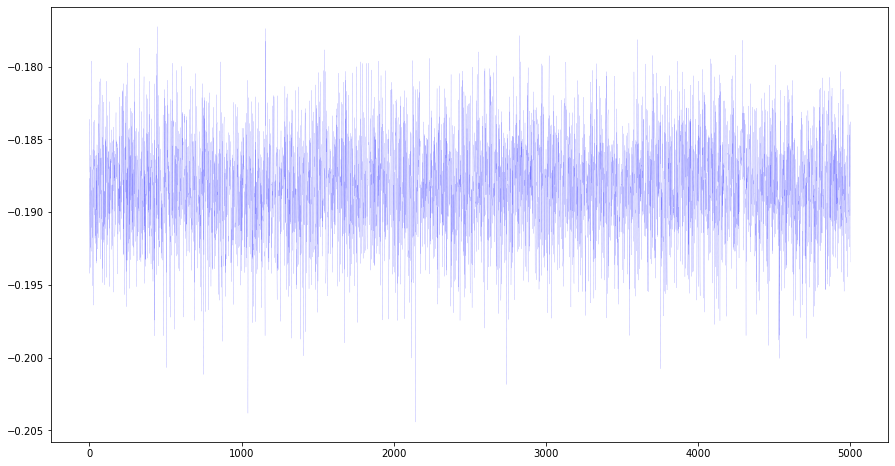

In [9]:
#####value loss plot#####
val_tpe = val
#val_mtpe = val

fig = plt.figure(figsize = (15,8))
plt.plot(val_tpe, 'b--', linewidth = 0.1, label = 'TPE')
plt.plot(val_mtpe, 'r--', linewidth = 0.1, label = 'MTPE')
plt.title('Optimized Values of XGBoost Regressor (aging rate)')
plt.xlabel('Iterations')
plt.ylabel('Values')
#plt.ylim((0.94, 0.97))
plt.legend(loc = 'lower right', frameon = False)

In [ ]:
##### hyperparameter importance #####
start = time.time()

#importances = optuna.importance.get_param_importances(study)
#importances.optuna.importance.get_param_importances(study, evaluator = optuna.importance.FanovaImportanceEvaluator())

importance_fig = optuna.visualization.plot_param_importances(study)
importance_fig.show()

end = time.time()
print("\nRun Time：%f seconds" % (end - start))

### Regression


 Dataset 0:
Best Threshold: 1.4111308701103553e-05 

Recall: [0.77777778] ,   Precision: [0.00031497] ,   Aging Rate: [0.7950915]

 Dataset 1:
Best Threshold: 1.368876746710157e-05 

Recall: [0.77777778] ,   Precision: [0.00035489] ,   Aging Rate: [0.70566875]

 Dataset 2:
Best Threshold: 5.155320650374051e-06 

Recall: [0.77777778] ,   Precision: [0.00035752] ,   Aging Rate: [0.70048119]

 Dataset 3:
Best Threshold: 1.5913157767499797e-05 

Recall: [0.77777778] ,   Precision: [0.00035657] ,   Aging Rate: [0.70234156]

 Dataset 4:
Best Threshold: 1.4325873053167015e-05 

Recall: [0.77777778] ,   Precision: [0.0003991] ,   Aging Rate: [0.62749763]

 Dataset 5:
Best Threshold: 0.04456144571304321 

Recall: [0.77777778] ,   Precision: [0.00032061] ,   Aging Rate: [0.78112087]

 Dataset 6:
Best Threshold: 0.05763113871216774 

Recall: [0.77777778] ,   Precision: [0.00033041] ,   Aging Rate: [0.75795574]

 Dataset 7:
Best Threshold: 0.25790950655937195 

Recall: [0.77777778] ,   Precision:

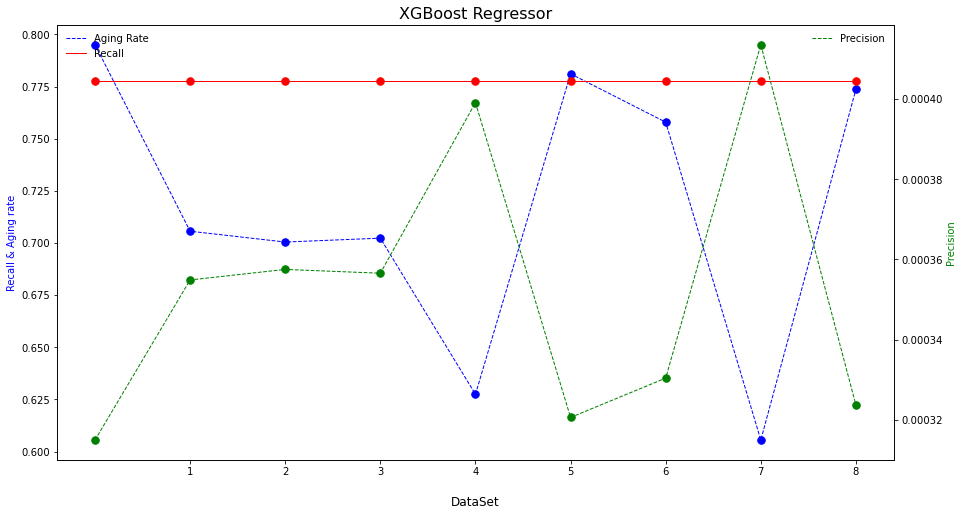


Run Time：64.737629 seconds


In [16]:
start = time.time()

# run_reg_param = {
#         'objective': 'binary:logistic',
#         'eval_metric': 'logloss',
#         'n_estimators': 250,
#         'subsample': 0.9,
#         'min_child_weight': 21,
#         'max_depth': 11,
#         'learning_rate': 0.175,
#         'reg_alpha': 0.0005,
#         'reg_lambda': 0.03,
# } #multi-tpe/auc/set6

run_reg_param = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'n_estimators': 150,
        'subsample': 0.7,
        'min_child_weight': 9,
        'max_depth': 7,
        'learning_rate': 0.325,
        'reg_alpha': 0.25,
        'reg_lambda': 0.06
} #tpe/auc/set6

# pr_dict, table_set2, bad_set2 = runall_XGBoostR(9, trainset_x, test_x, trainset_y, test_y, event_reg_param, 
#                                                 thres_target = 'Recall', threshold = 0.8)
pr_dict, table_set2 = runall_XGBoostR(9, trainset_x, run_test_x, trainset_y, run_test_y, run_reg_param, 
                                       thres_target = 'Recall', threshold = 0.7, record_bad = False)
line_chart(table_set2, title = 'XGBoost Regressor')
#bad_plot(bad_set2)

end = time.time()
print("\nRun Time：%f seconds" % (end - start))

,Class_Prob,train_OK,train_NG,Balance Ratio,TP,FP,FN,TN,Recall,Precision,Aging Rate,Efficiency,Score
dataset 0,0.000014,79742.0,653.0,122.116386,14.0,44434.0,4.0,11451.0,0.777778,0.000315,0.795091,0.978224,0.000000
dataset 1,0.000014,79742.0,39869.0,2.000100,14.0,39435.0,4.0,16450.0,0.777778,0.000355,0.705669,1.102185,0.577871
dataset 2,0.000005,79742.0,40197.0,1.983780,14.0,39145.0,4.0,16740.0,0.777778,0.000358,0.700481,1.110348,0.580886
dataset 3,0.000016,79742.0,40197.0,1.983780,14.0,39249.0,4.0,16636.0,0.777778,0.000357,0.702342,1.107407,0.579801
dataset 4,0.000014,79742.0,39871.0,2.000000,14.0,35065.0,4.0,20820.0,0.777778,0.000399,0.627498,1.239491,0.627082
dataset 5,0.044561,3265.0,1637.0,1.994502,14.0,43653.0,4.0,12232.0,0.777778,0.000321,0.781121,0.995720,0.000000
dataset 6,0.057631,3265.0,1959.0,1.666667,14.0,42358.0,4.0,13527.0,0.777778,0.000330,0.757956,1.026152,0.549219
dataset 7,0.257910,3265.0,1959.0,1.666667,14.0,33839.0,4.0,22046.0,0.777778,0.000414,0.605567,1.284380,0.642518
dataset 8,0.048722,3265.0,1632.0,2.000613,14.0,43236.0,4.0,12649.0,0.777778,0.000324,0.773662,1.005320,0.541181


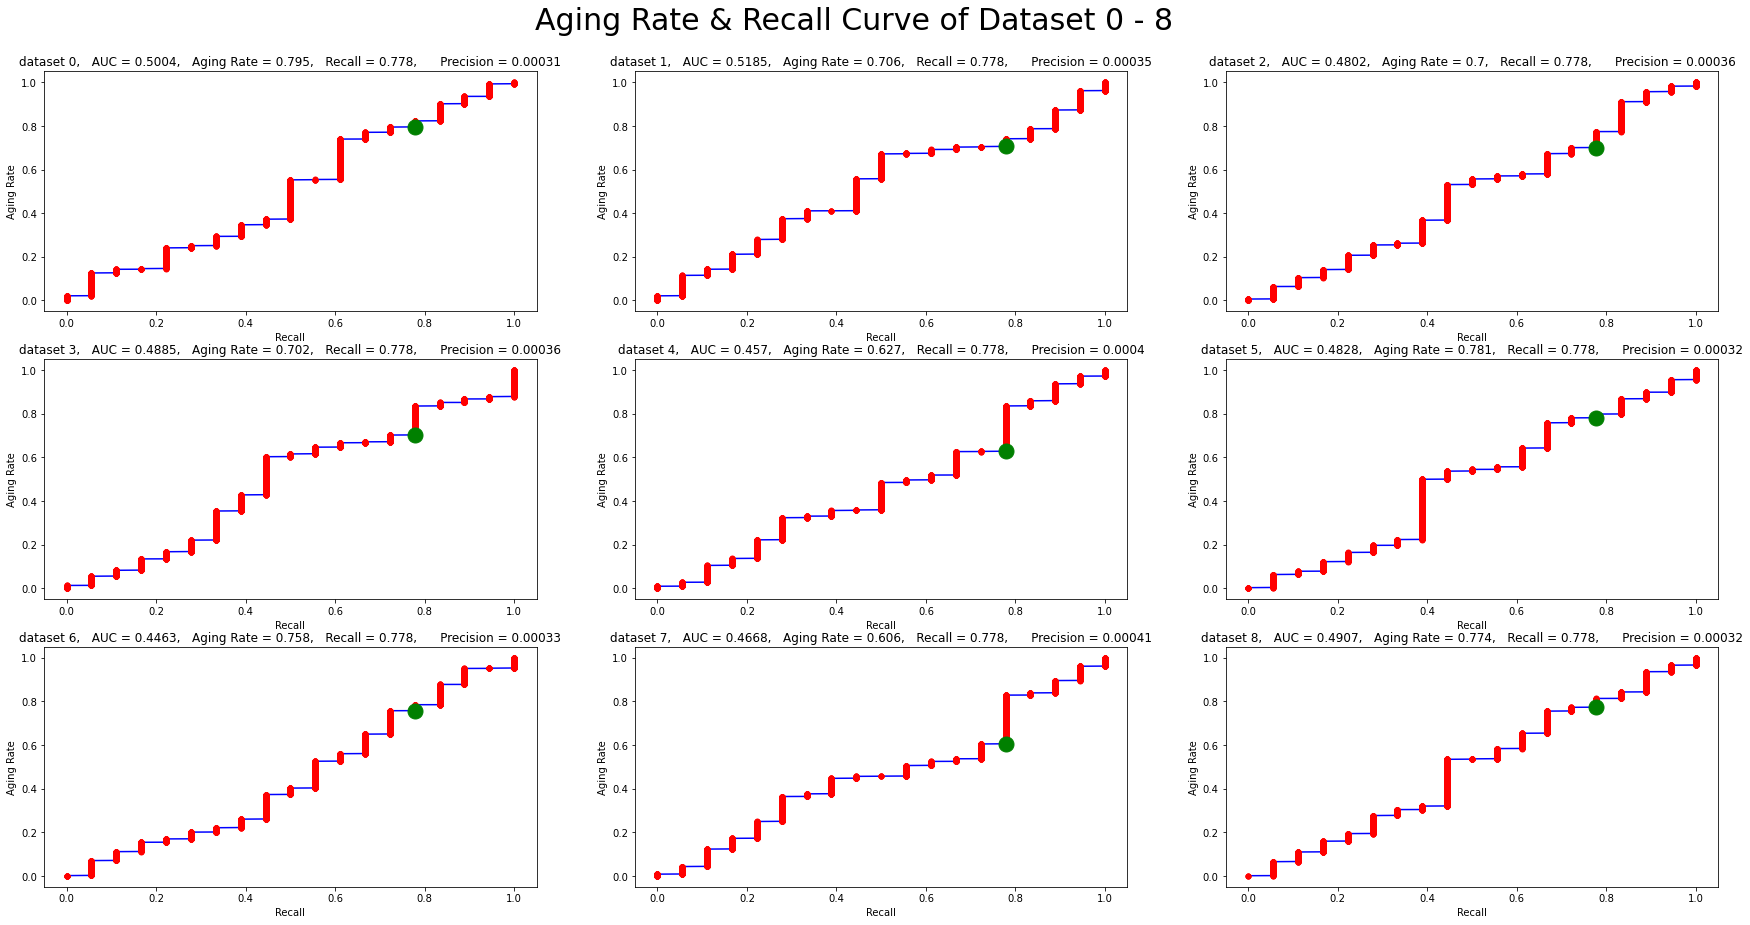

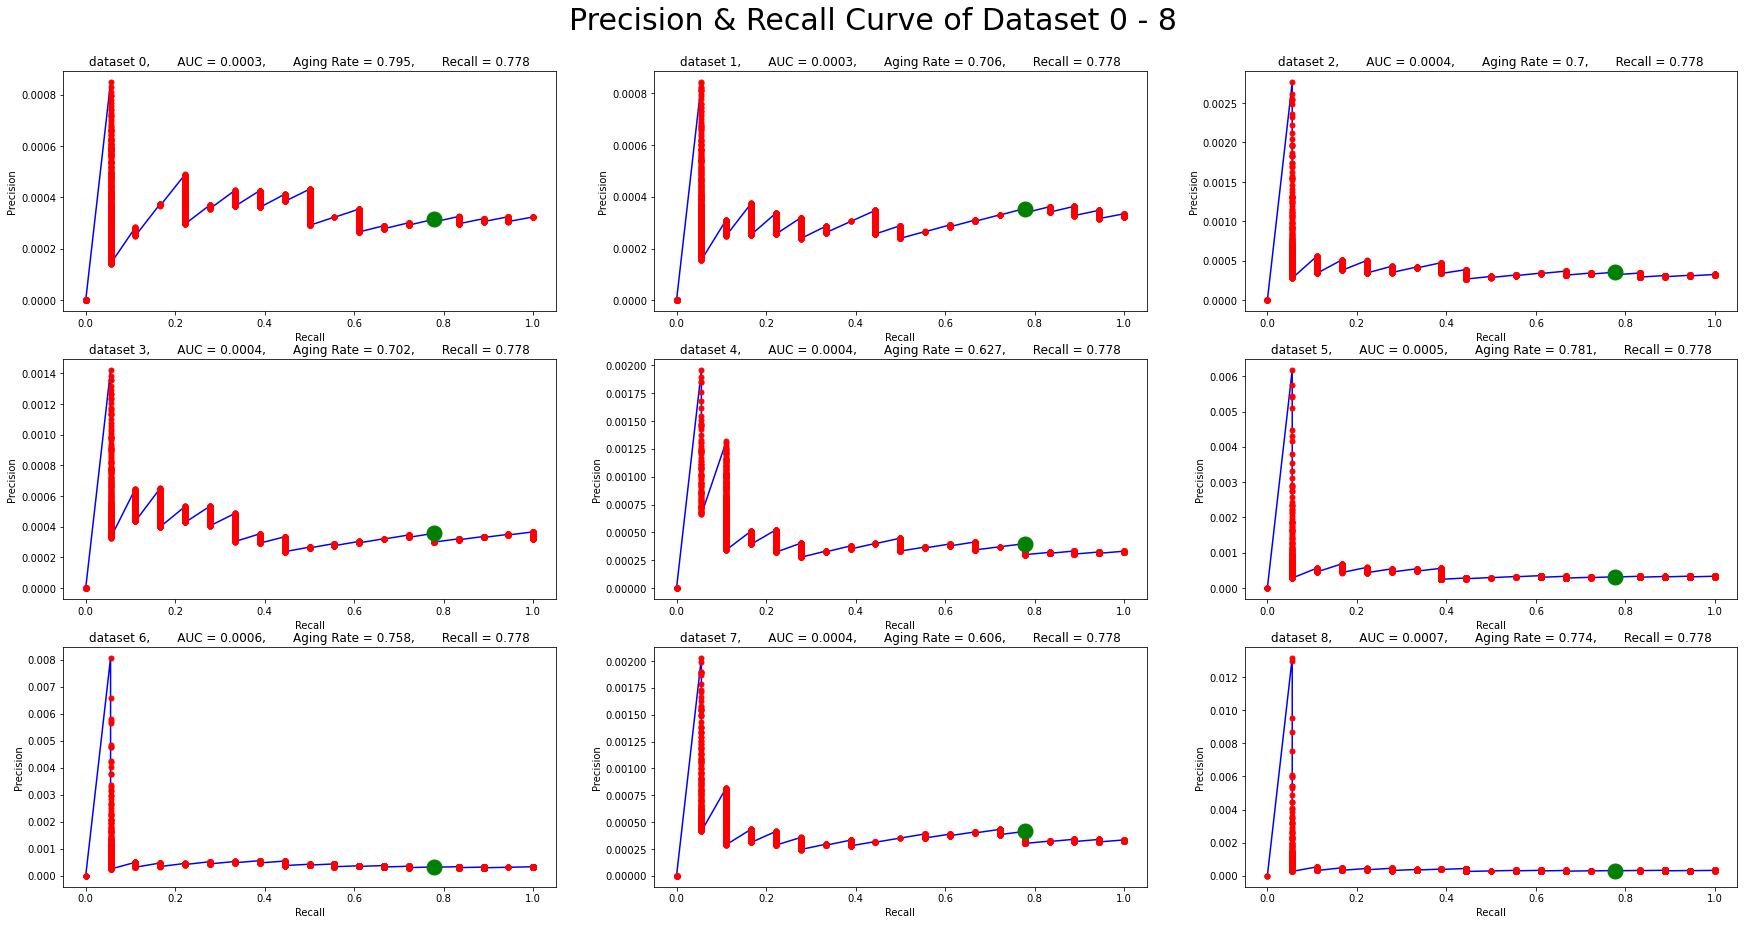

In [17]:
multiple_curve(3, 3, pr_dict, table_set2, target = 'Aging Rate')
multiple_curve(3, 3, pr_dict, table_set2, target = 'Precision')
table_set2

### Grid Search

In [ ]:
start = time.time()

clf = xgb.XGBClassifier(n_estimators = 50, 
                        learning_rate = 0.1, 
                        min_child_weight = 4, 
                        subsample = 0.7, 
                        max_depth = 9, 
                        reg_lambda = 0.2
                       )

reg = xgb.XGBRegressor(n_estimators = 200, 
                        learning_rate = 0.1, 
                        min_child_weight = 4, 
                        subsample = 0.7, 
                        max_depth = 7, 
                        reg_lambda = 0.2
                       )

param_dict = {
            'n_estimators': [100, 150,200],
            'learning_rate': [0.1, 0.2],
            'min_child_weight': [4, 5, 6, 7, 8],
            'subsample': [0.7],
            'max_depth': [3, 5, 7, 9],
            'reg_lambda':np.array([0.2])
            }

fit_params = {'early_stopping_rounds': 10}

grid_search = GridSearchCV(clf, param_grid = param_dict, scoring = 'precision', cv = 3, verbose = 10, n_jobs = -1)

train_x, train_y = label_divide(data_dict['set5'], None, train_only = True)
result = grid_search.fit(train_x, train_y)

end = time.time()
print("\nRun Time：%f seconds" % (end - start))